## Dataset Preparation (Convolutional Neural Networks)

In [ ]:
# Import OS
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Import PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# Import Torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import Random
import random

# Import Numpy
import numpy as np

# Import Matplotlib
import matplotlib.pyplot as plt

# Import CV2
import cv2

# Import Skimage
from skimage import color
from skimage.feature import SIFT, ORB, fisher_vector, learn_gmm

# Import Sklearn
from sklearn.svm import SVC, LinearSVC
from sklearn.cluster  import KMeans
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Check Verisions
print(f"PyTorch version: {torch.__version__} \ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.1.2+cpu 
torchvision version: 0.16.2+cpu


### Loading the CIFAR-100 Dataset

In [ ]:
# Load the CIFAR-100 dataset, Train
cifar100_train = datasets.CIFAR100(
    root='./data',
    train=True,
    transform=None,
    target_transform=None,
    download=True
)

# Load the CIFAR-100 dataset, Test
cifar100_test = datasets.CIFAR100(
    root='./data',
    train=False,
    transform=None,
    target_transform=None,
    download=True
)

Files already downloaded and verified
Files already downloaded and verified


### Randomly choosing a selected number of classes (n =15)

In [ ]:
def select_classes(num_classes):
     # Set the random seed for reproducibility
    random.seed(42)

    # Randomly select `num_classes` from the CIFAR-100 dataset
    selected_classes = random.sample(range(100), num_classes)

    # Filter training data
    train_images = []
    train_labels = []
    for idx, (image, label) in enumerate(cifar100_train):
        if label in selected_classes:
            image = np.array(image)
            train_images.append(image)
            train_labels.append(label)

    # Filter testing data
    test_images = []
    test_labels = []
    for idx, (image, label) in enumerate(cifar100_test):
        if label in selected_classes:
            image = np.array(image)
            test_images.append(image)
            test_labels.append(label)

    return train_images, train_labels, test_images, test_labels, selected_classes

# Select 15 classes from CIFAR-100
num_classes = 15
train_images, train_labels, test_images, test_labels, selected_classes = select_classes(num_classes)

print("Selected Classes:", selected_classes)
print("Number of Training Samples:", len(train_images))
print("Number of Testing Samples:", len(test_images))

Selected Classes: [81, 14, 3, 94, 35, 31, 28, 17, 13, 86, 69, 11, 75, 54, 4]
Number of Training Samples: 7500
Number of Testing Samples: 1500


In [ ]:
class_names = [cifar100_test.classes[i] for i in selected_classes]
class_names

['streetcar',
 'butterfly',
 'bear',
 'wardrobe',
 'girl',
 'elephant',
 'cup',
 'castle',
 'bus',
 'telephone',
 'rocket',
 'boy',
 'skunk',
 'orchid',
 'beaver']

### Image Resizing

In [ ]:
def resize_images(images, new_size):
    resized_images = []

    for image in images:
        resized_image = cv2.resize(image, new_size)
        resized_images.append(resized_image)

    return resized_images

In [ ]:
image_size = 160

train_images = resize_images(train_images, (image_size, image_size))
test_images = resize_images(test_images, (image_size, image_size))

### Color Space Conversion

In [ ]:
def convert_grayscale(images):
    gray_images = []

    for image in images:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        gray_images.append((gray_image))

    return gray_images

In [ ]:
train_images = convert_grayscale(train_images)
test_images = convert_grayscale(test_images)

### Contrast Enhancement

In [ ]:
def equalize_image(dataset):
    equalized_images = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    for image in dataset:
        equalized_image = clahe.apply(image)
        equalized_images.append(equalized_image)

    return equalized_images

In [ ]:
train_images = equalize_image(train_images)
test_images = equalize_image(test_images)

### Tensor Transformation

In [ ]:
to_tensor = transforms.ToTensor()

train_images = [to_tensor(img) for img in train_images]
test_images = [to_tensor(img) for img in test_images]

In [ ]:
train_images[0], train_images[0].shape, train_images[0].dtype

(tensor([[[0.6039, 0.6039, 0.6039,  ..., 0.6510, 0.6510, 0.6510],
          [0.6039, 0.6039, 0.6039,  ..., 0.6510, 0.6510, 0.6510],
          [0.6039, 0.6039, 0.6039,  ..., 0.6510, 0.6510, 0.6510],
          ...,
          [0.2275, 0.2275, 0.2275,  ..., 0.9059, 0.9059, 0.9059],
          [0.2275, 0.2275, 0.2275,  ..., 0.9059, 0.9059, 0.9059],
          [0.2275, 0.2275, 0.2275,  ..., 0.9059, 0.9059, 0.9059]]]),
 torch.Size([1, 160, 160]),
 torch.float32)

### Normalization

In [ ]:
# Concatenate the tensors
concatenated_train_images = torch.stack(train_images)
concatenated_test_images = torch.stack(test_images)

# Compute mean and standard deviation
mean = concatenated_train_images.mean(dim=(0, 2, 3))
std = concatenated_train_images.std(dim=(0, 2, 3))

# Define normalization transformation
normalize = transforms.Normalize(mean=mean, std=std)

# Apply normalization to each tensor
train_images = [normalize(img) for img in train_images]
test_images = [normalize(img) for img in test_images]

In [ ]:
train_images[0], train_images[0].shape, train_images[0].size

(tensor([[[ 0.2902,  0.2902,  0.2902,  ...,  0.4767,  0.4767,  0.4767],
          [ 0.2902,  0.2902,  0.2902,  ...,  0.4767,  0.4767,  0.4767],
          [ 0.2902,  0.2902,  0.2902,  ...,  0.4767,  0.4767,  0.4767],
          ...,
          [-1.2016, -1.2016, -1.2016,  ...,  1.4868,  1.4868,  1.4868],
          [-1.2016, -1.2016, -1.2016,  ...,  1.4868,  1.4868,  1.4868],
          [-1.2016, -1.2016, -1.2016,  ...,  1.4868,  1.4868,  1.4868]]]),
 torch.Size([1, 160, 160]),
 <function Tensor.size>)

### Preparing Dataset

In [ ]:
def prepare_dataset(images, labels):
    data = []

    for image, label in zip(images, labels):
        data.append((image, label))

    return data

In [ ]:
train_data = prepare_dataset(train_images, train_labels)
test_data = prepare_dataset(test_images, test_labels)

### Remapping indexes to selected classes

In [ ]:
class_mapping = {}

for idx, class_idx in enumerate(selected_classes):
    class_mapping[class_idx] = idx

print(class_mapping)

{81: 0, 14: 1, 3: 2, 94: 3, 35: 4, 31: 5, 28: 6, 17: 7, 13: 8, 86: 9, 69: 10, 11: 11, 75: 12, 54: 13, 4: 14}


In [ ]:
def prepare_dataset(images, labels, class_mapping):
    data = []

    for image, label in zip(images, labels):
        # Remapping indexes to selected classes
        subset_label = class_mapping[label]
        data.append((image, subset_label))

    return data

In [ ]:
train_data = prepare_dataset(train_images, train_labels, class_mapping)
test_data = prepare_dataset(test_images, test_labels, class_mapping)

### Batching

In [ ]:
batch_size = 32

train_dataloader = DataLoader(train_data,
    batch_size = batch_size,
    shuffle = True
)

test_dataloader = DataLoader(test_data,
    batch_size = batch_size,
    shuffle = False
)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {batch_size}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {batch_size}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000021EC618F290>, <torch.utils.data.dataloader.DataLoader object at 0x0000021EC5C1F390>)
Length of train dataloader: 235 batches of 32
Length of test dataloader: 47 batches of 32


In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 160, 160]), torch.Size([32]))

Image size: torch.Size([1, 160, 160])
Label: 4, label size: torch.Size([])


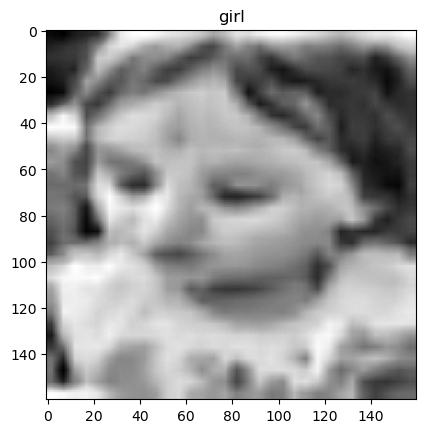

In [ ]:
# Display sample image
torch.manual_seed(42)

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]

plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])

print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

##  Convolutional Neural Networks approach

 ### Download a helper functions file from a GitHub repository

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


### Function to track the time taken

In [ ]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### Construct CNN

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class CIFAR100_V2(nn.Module):
    """
    Model architecture of TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * (image_size // 4) * (image_size // 4), out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

# Display the information for each layer in the model
torch.manual_seed(42)

cifar100_v2 = CIFAR100_V2(input_shape=1,
    hidden_units= 20,
    output_shape=len(class_names)).to(device)
cifar100_v2

CIFAR100_V2(
  (block_1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32000, out_features=15, bias=True)
  )
)

### Construct Train & Test steps

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=cifar100_v2.parameters(),
                             lr=0.001)

# Train Step
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

# Test Step
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1)
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

### Train & Test

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm
from helper_functions import accuracy_fn

torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start = timer()

# Train and test model
epochs = 16

loss_list=[]
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=cifar100_v2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=cifar100_v2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end = timer()
total_train_time = print_train_time(start=train_time_start,
                                           end=train_time_end,
                                           device=device)

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.69645 | Train accuracy: 9.06%
Test loss: 2.67628 | Test accuracy: 13.32%

Epoch: 1
---------
Train loss: 2.60600 | Train accuracy: 17.54%
Test loss: 2.49699 | Test accuracy: 20.68%

Epoch: 2
---------
Train loss: 2.38322 | Train accuracy: 24.41%
Test loss: 2.39572 | Test accuracy: 24.16%

Epoch: 3
---------
Train loss: 2.29343 | Train accuracy: 28.45%
Test loss: 2.47267 | Test accuracy: 21.01%

Epoch: 4
---------
Train loss: 2.24119 | Train accuracy: 30.54%
Test loss: 2.37342 | Test accuracy: 25.96%

Epoch: 5
---------
Train loss: 2.19503 | Train accuracy: 30.95%
Test loss: 2.41429 | Test accuracy: 24.27%

Epoch: 6
---------
Train loss: 2.15618 | Train accuracy: 32.97%
Test loss: 2.34002 | Test accuracy: 26.08%

Epoch: 7
---------
Train loss: 2.11756 | Train accuracy: 34.03%
Test loss: 2.31754 | Test accuracy: 28.08%

Epoch: 8
---------
Train loss: 2.07169 | Train accuracy: 35.45%
Test loss: 2.32199 | Test accuracy: 26.41%

Epoch: 9
---------
Train loss

### Model Evaluation

In [ ]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

cifar100_v2_results = eval_model(
    model=cifar100_v2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
cifar100_v2_results

{'model_name': 'CIFAR100_V2',
 'model_loss': 1.9606947898864746,
 'model_acc': 38.73480243161094}